In [1]:
import re
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import nltk
import kagglehub
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from collections import Counter

# 1. Dataset Preparation


In [2]:
path = kagglehub.dataset_download(
    "suchintikasarkar/sentiment-analysis-for-mental-health"
)
print("Path to dataset files:", path)

Path to dataset files: /home/cici/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1


In [3]:
df = pd.read_csv(path + "/Combined Data.csv")
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [5]:
df = df.dropna()

In [6]:
dups = df.duplicated(subset=["statement"]).sum()
print(f"Total duplicate statements in entire dataset: {dups}")

dups_per_status = (
    df[df.duplicated(subset=["statement"], keep=False)].groupby("status").size()
)
print("\nDuplicates found per status:")
print(dups_per_status)

df = df.drop_duplicates(subset=["statement"], keep="first").copy()

Total duplicate statements in entire dataset: 1608

Duplicates found per status:
status
Anxiety                 433
Bipolar                 552
Depression              601
Normal                  463
Personality disorder    362
Stress                  574
Suicidal                 26
dtype: int64


# 2. Dataset Analysis


## 2.1. Exploratory Data Analysis (EDA)


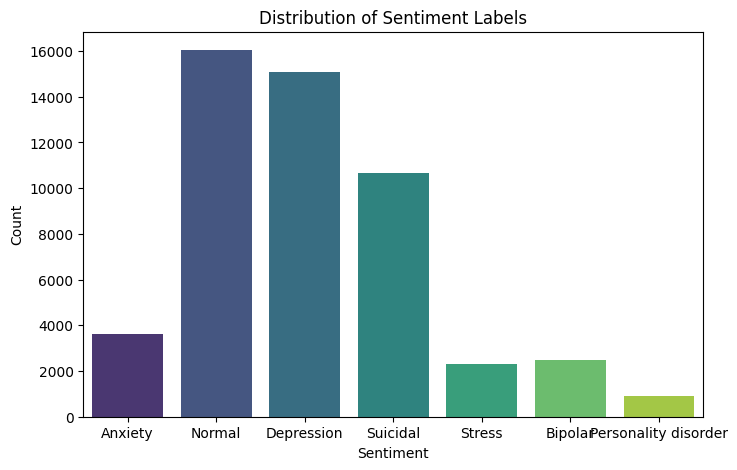

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(x="status", data=df, hue="status", palette="viridis", legend=False)
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [8]:
drop = ["Anxiety", "Stress", "Bipolar", "Personality disorder"]

df = df[~df["status"].isin(drop)].copy()
df = df.reset_index(drop=True)

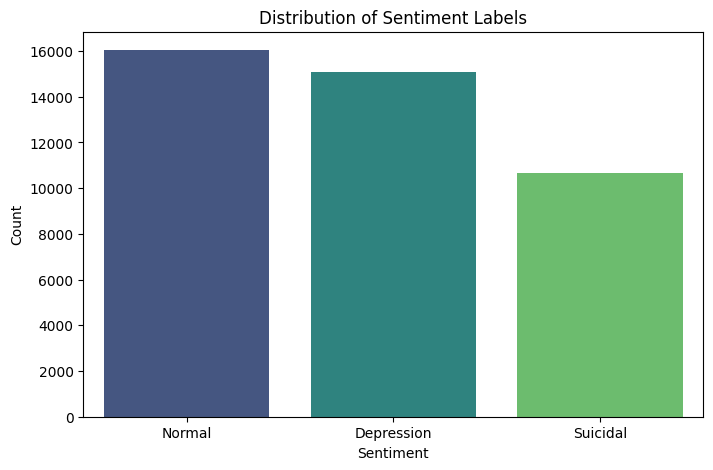

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(x="status", data=df, hue="status", palette="viridis", legend=False)
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

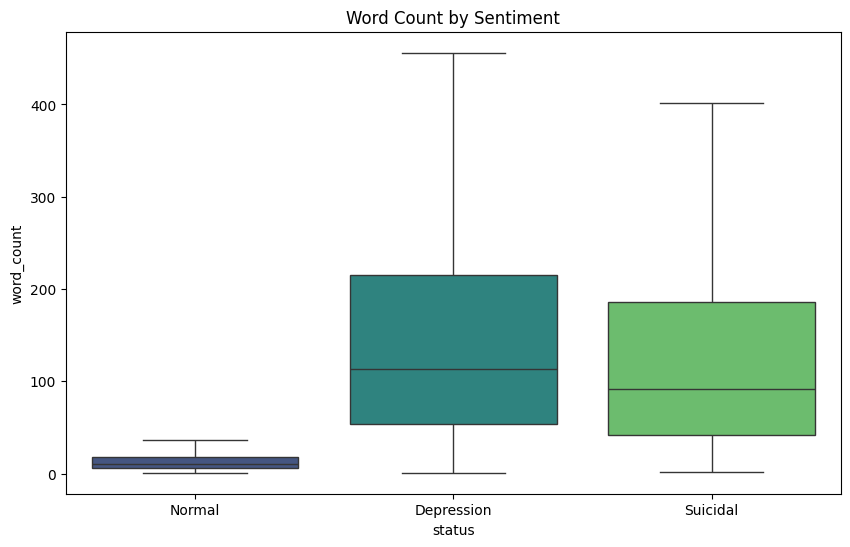

In [10]:
df["word_count"] = df["statement"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="status",
    y="word_count",
    data=df,
    hue="status",
    palette="viridis",
    legend=False,
    showfliers=False,
)
plt.title("Word Count by Sentiment")
plt.show()

## 2.2. Manual Analysis for Some Samples


# 3. Dataset Preprocessing


In [11]:
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger_eng")

lemmatizer = WordNetLemmatizer()


def get_wordnet_pos(nltk_tag):
    if nltk_tag.startswith("J"):
        return wordnet.ADJ
    elif nltk_tag.startswith("V"):
        return wordnet.VERB
    elif nltk_tag.startswith("N"):
        return wordnet.NOUN
    elif nltk_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def preprocess(text):
    # 1. Cleaning
    text = str(text).encode("ascii", "ignore").decode()
    text = re.sub(r"https?:\/\/\S+|www\.\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = text.lower()

    # 2. Tokenization
    pattern = r"\w+(?:'\w+)?|[^\w\s]+"
    tokens = re.findall(pattern, text)

    # 3. Batch POS Tagging (Faster than tagging word-by-word)
    tagged_tokens = nltk.pos_tag(tokens)

    # 4. Lemmatization with POS context
    clean_tokens = []
    for word, tag in tagged_tokens:
        if re.match(r"\w+", word):
            pos = get_wordnet_pos(tag)
            clean_tokens.append(lemmatizer.lemmatize(word, pos))
        else:
            clean_tokens.append(word)

    return " ".join(clean_tokens)


df["statement_processed"] = df["statement"].apply(preprocess)

[nltk_data] Downloading package wordnet to /home/cici/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/cici/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [ ]:
def top_words_per_class(
    df, text_col="statement_processed", label_col="status", top_k=20
):
    unique_statuses = df[label_col].unique()

    top_words_dict = {}

    for status in unique_statuses:
        subset = df[df[label_col] == status][text_col]

        vec = CountVectorizer(ngram_range=(1, 1)).fit(subset)
        bag_of_words = vec.transform(subset)
        sum_words = bag_of_words.sum(axis=0)

        words_freq = [
            (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()
        ]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]

        top_words_dict[status] = [word for word, freq in words_freq]

    comparison_df = pd.DataFrame(top_words_dict)
    return comparison_df


top_words_df = top_words_per_class(df)
print(top_words_df)

   Normal Depression Suicidal
0      be         be       be
1      to         to       to
2     the        and      and
3     and        the       my
4      it         my      the
5     you       have     have
6      my         it      not
7    have         do       do
8      of        not       it
9    that         of       me
10     in         me       of
11    for       that     that
12     do         in       in
13     me        but      but
14    but        for     just
15   this       just      for
16   with       feel     want
17     on       this     this
18     so         so       so
19    not       like     feel


In [13]:
custom_stop_words = [
    "to",
    "the",
    "and",
    "of",
    "in",
    "for",
    "with",
    "on",
    "that",
    "this",
    "it",
    "is",
    "be",
    "wa",
    "so",
    "but",
    "or",
    "as",
    "at",
    "by",
]


def remove_stop_words(text):
    tokens = text.split()
    filtered_tokens = [t for t in tokens if t not in custom_stop_words]
    return " ".join(filtered_tokens)


df["statement_processed"] = df["statement_processed"].apply(remove_stop_words)

print(df[["status", "statement_processed"]].head())

   status                                statement_processed
0  Normal              gr gr dreaming ex crush my game , god
1  Normal                                 wkwkwk what a joke
2  Normal  leaf also standby front pc ... because office ...
3  Normal     thank god even though it's just a ride through
4  Normal  wed teaser concept use song day6 - only , soun...


In [14]:
def ngram_comparison(df, status_label, text_col="statement_processed", top_k=10):
    subset = df[df["status"] == status_label][text_col]

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    plt.subplots_adjust(wspace=0.4)

    n_ranges = [(1, 1), (2, 2), (3, 3)]
    titles = ["Unigrams", "Bigrams", "Trigrams"]
    colors = ["#4A90E2", "#50E3C2", "#F5A623"]

    for i, (n_range, title, color) in enumerate(zip(n_ranges, titles, colors)):
        vec = CountVectorizer(ngram_range=n_range, stop_words=None).fit(subset)
        bag_of_words = vec.transform(subset)
        sum_words = bag_of_words.sum(axis=0)

        words_freq = [
            (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()
        ]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]

        if words_freq:
            words, counts = zip(*words_freq)
            sns.barplot(x=list(counts), y=list(words), ax=axes[i], color=color)
            axes[i].set_title(f"{status_label.upper()}: {title}")
            axes[i].set_xlabel("Frequency")

    plt.show()

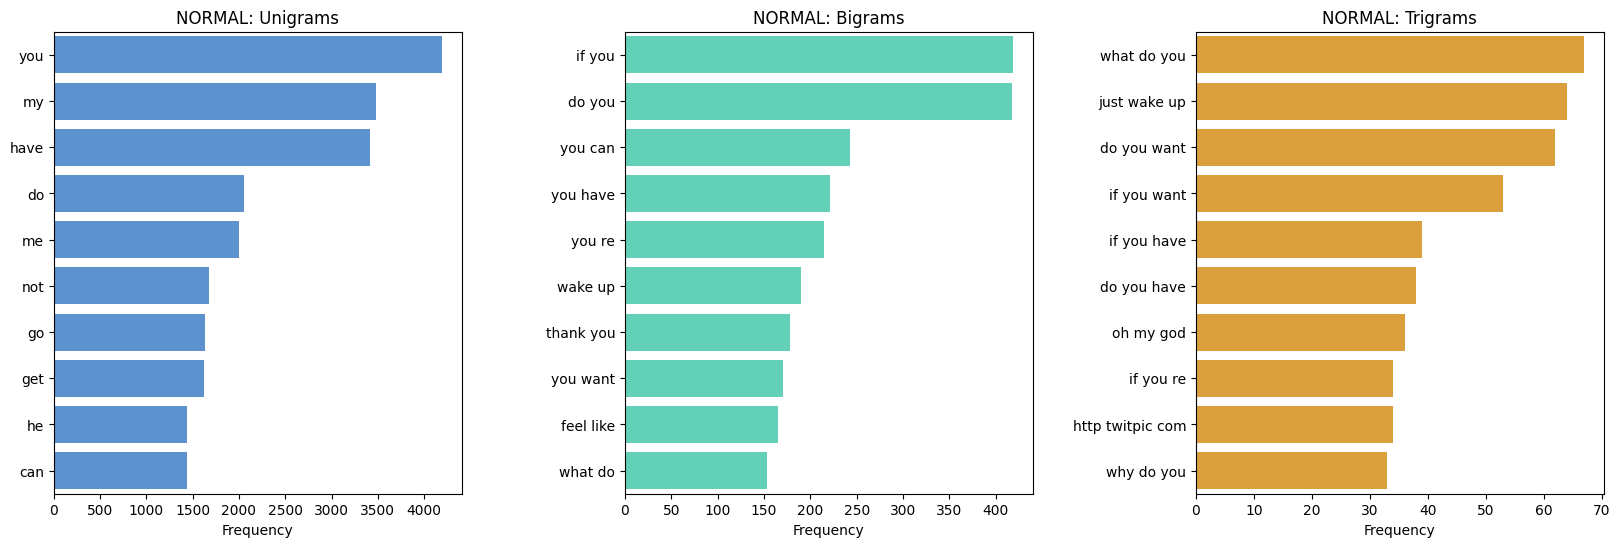

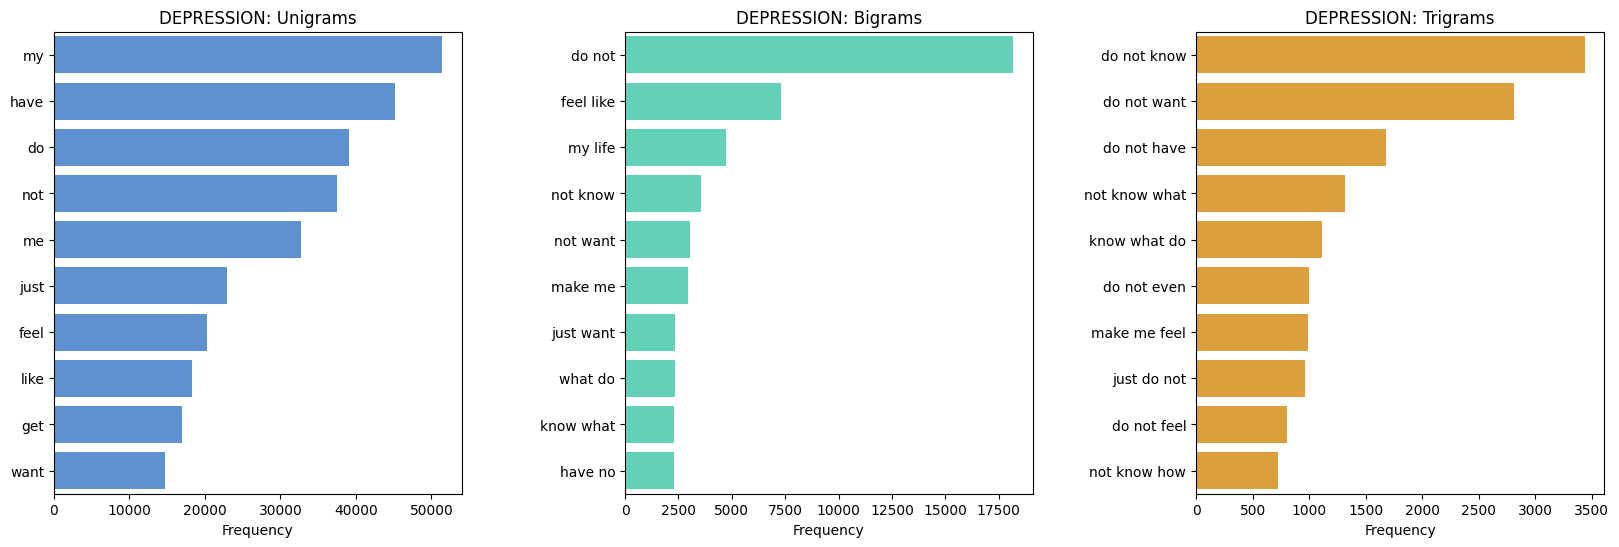

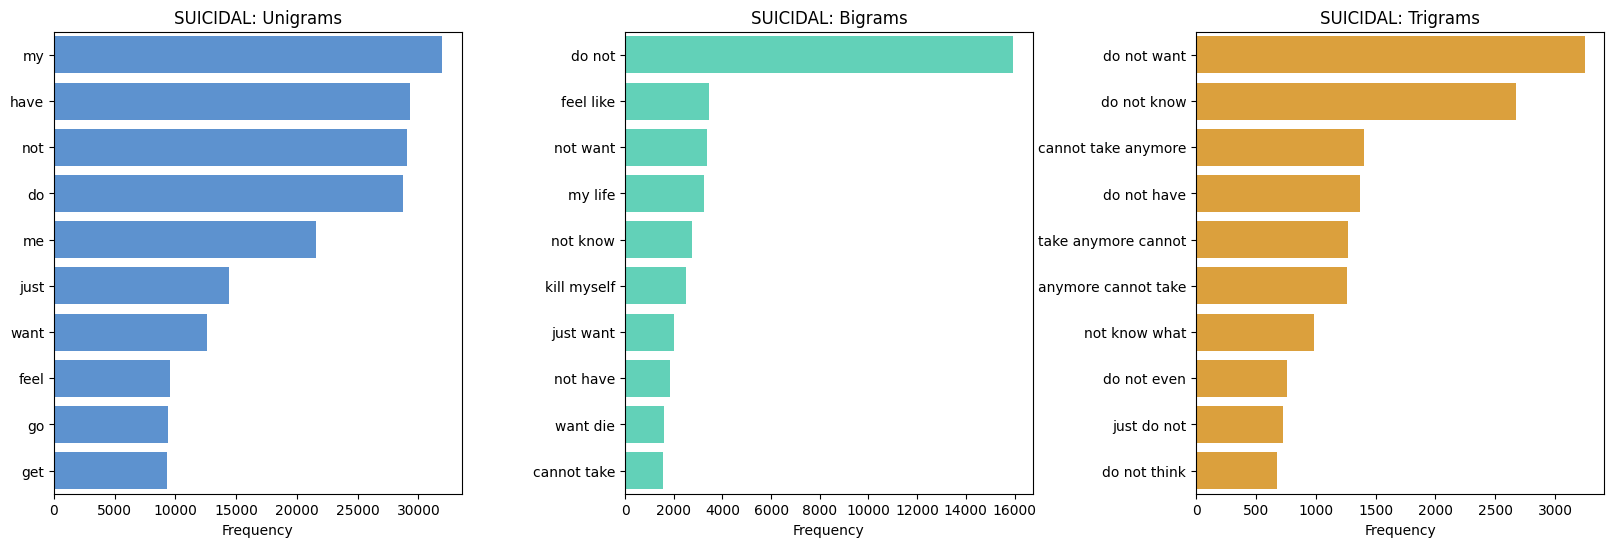

In [15]:
ngram_comparison(df, status_label="Normal")
ngram_comparison(df, status_label="Depression")
ngram_comparison(df, status_label="Suicidal")

# 4. Model Training and Hyperparameter Tuning


In [16]:
SEED = 42
MODEL_DIR = "models"
STUDY_DIR = "studies"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(STUDY_DIR, exist_ok=True)

In [17]:
X = df["statement_processed"]
y = df["status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

In [40]:
print(f"Total samples: {X.shape[0]}")
print(f"Total training samples: {X_train.shape[0]}")
print(f"Total testing samples: {X_test.shape[0]}")

Total samples: 41767
Total training samples: 33413
Total testing samples: 8354


In [18]:
sampler = optuna.samplers.TPESampler(seed=SEED)

## 4.1. Multinomial Naive Bayes


In [19]:
def nb_objective(trial):
    max_features = trial.suggest_int("tfidf__max_features", 5000, 20000, step=500)
    max_df = trial.suggest_float("tfidf__max_df", 0.8, 0.95)
    min_df = trial.suggest_int("tfidf__min_df", 2, 7)

    alpha = trial.suggest_float("nb__alpha", 1e-3, 10.0, log=True)

    fit_prior = trial.suggest_categorical("nb__fit_prior", [True, False])

    pipeline = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, 3),
                    token_pattern=r"\S+",
                    max_features=max_features,
                    max_df=max_df,
                    min_df=min_df,
                ),
            ),
            (
                "nb",
                MultinomialNB(alpha=alpha, fit_prior=fit_prior),
            ),
        ]
    )

    score = cross_val_score(
        pipeline, X_train, y_train, cv=5, scoring="f1_macro", n_jobs=-1
    )

    return score.mean()

In [37]:
study_nb = optuna.create_study(direction="maximize", sampler=sampler)
study_nb.optimize(nb_objective, n_trials=30, n_jobs=-1)

print(f"Best NB Score: {study_nb.best_value}")
print(f"Best NB Params :{study_nb.best_params}")

[I 2026-01-13 22:53:26,548] A new study created in memory with name: no-name-72db808c-d2eb-49ec-baf6-96b44f0f2c01
[I 2026-01-13 22:53:52,938] Trial 4 finished with value: 0.755716227093774 and parameters: {'tfidf__max_features': 11000, 'tfidf__max_df': 0.9218515819018909, 'tfidf__min_df': 7, 'nb__alpha': 0.017874531871734853, 'nb__fit_prior': False}. Best is trial 4 with value: 0.755716227093774.
[I 2026-01-13 22:53:53,958] Trial 2 finished with value: 0.7710893560935314 and parameters: {'tfidf__max_features': 11500, 'tfidf__max_df': 0.8257594740880653, 'tfidf__min_df': 4, 'nb__alpha': 0.32439056508263203, 'nb__fit_prior': True}. Best is trial 2 with value: 0.7710893560935314.
[I 2026-01-13 22:53:54,683] Trial 1 finished with value: 0.7676876701314652 and parameters: {'tfidf__max_features': 18500, 'tfidf__max_df': 0.9158123885192062, 'tfidf__min_df': 7, 'nb__alpha': 0.006858555528392422, 'nb__fit_prior': True}. Best is trial 2 with value: 0.7710893560935314.
[I 2026-01-13 22:54:15,608]

Best NB Score: 0.7732494543889095
Best NB Params :{'tfidf__max_features': 20000, 'tfidf__max_df': 0.8929877078163878, 'tfidf__min_df': 4, 'nb__alpha': 0.12843204449792203, 'nb__fit_prior': True}


## 4.2. Softmax Regression (Multinomial Logistic Regression)


In [21]:
def lr_objective(trial):
    max_features = trial.suggest_int("tfidf__max_features", 5000, 20000, step=500)
    max_df = trial.suggest_float("tfidf__max_df", 0.8, 0.95)
    min_df = trial.suggest_int("tfidf__min_df", 2, 7)

    solver = trial.suggest_categorical("lr__solver", ["lbfgs", "saga"])
    C = trial.suggest_float("lr__C", 0.1, 10, log=True)

    penalty = "l2"
    if solver == "saga":
        penalty = trial.suggest_categorical("lr__penalty", ["l1", "l2"])

    pipeline = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, 3),
                    token_pattern=r"\S+",
                    max_features=max_features,
                    max_df=max_df,
                    min_df=min_df,
                ),
            ),
            (
                "lr",
                LogisticRegression(
                    max_iter=5000,
                    solver=solver,
                    penalty=penalty,
                    C=C,
                    class_weight="balanced",
                    random_state=SEED,
                ),
            ),
        ]
    )

    score = cross_val_score(
        pipeline, X_train, y_train, cv=5, scoring="f1_macro", n_jobs=-1
    )
    return score.mean()

In [23]:
study_lr = optuna.create_study(direction="maximize", sampler=sampler)
study_lr.optimize(lr_objective, n_trials=30, n_jobs=-1)

print(f"Best LR Score: {study_lr.best_value}")
print(f"Best LR Params :{study_lr.best_params}")

[I 2026-01-13 22:33:48,090] A new study created in memory with name: no-name-24fd6772-0679-413f-a77f-a2194510f4a8
/data/CiCi/code/projects/uit/cs221/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/data/CiCi/code/projects/uit/cs221/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/data/CiCi/code/projects/uit/cs221/.ve

Best LR Score: 0.806106526270255
Best LR Params :{'tfidf__max_features': 12500, 'tfidf__max_df': 0.9478542145816149, 'tfidf__min_df': 7, 'lr__solver': 'saga', 'lr__C': 1.3784778404565428, 'lr__penalty': 'l1'}


## 4.3. Linear Support Vector Classification (Linear SVC)


In [24]:
def svc_objective(trial):
    max_features = trial.suggest_int("tfidf__max_features", 5000, 20000, step=500)
    max_df = trial.suggest_float("tfidf__max_df", 0.8, 0.95)
    min_df = trial.suggest_int("tfidf__min_df", 2, 7)

    C = trial.suggest_float("svc__C", 0.01, 10, log=True)

    penalty = trial.suggest_categorical("svc__penalty", ["l1", "l2"])

    if penalty == "l1":
        loss = "squared_hinge"
        dual = False
    else:
        loss = trial.suggest_categorical("svc__loss", ["hinge", "squared_hinge"])
        dual = False if loss == "squared_hinge" else True

    pipeline = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, 3),
                    token_pattern=r"\S+",
                    max_features=max_features,
                    max_df=max_df,
                    min_df=min_df,
                ),
            ),
            (
                "svc",
                LinearSVC(
                    C=C,
                    penalty=penalty,
                    loss=loss,
                    dual=dual,
                    class_weight="balanced",
                    max_iter=5000,
                    random_state=SEED,
                ),
            ),
        ]
    )

    score = cross_val_score(
        pipeline, X_train, y_train, cv=5, scoring="f1_macro", n_jobs=-1
    )
    return score.mean()

In [25]:
study_svc = optuna.create_study(direction="maximize", sampler=sampler)
study_svc.optimize(svc_objective, n_trials=30, n_jobs=-1)

print(f"Best SVC Score: {study_svc.best_value}")
print(f"Best SVC Params :{study_svc.best_params}")

[I 2026-01-13 22:43:55,195] A new study created in memory with name: no-name-93de91c7-2739-49cc-b927-1432f02d7e86
[I 2026-01-13 22:44:25,206] Trial 4 finished with value: 0.8045934319637468 and parameters: {'tfidf__max_features': 10000, 'tfidf__max_df': 0.8184709706415032, 'tfidf__min_df': 3, 'svc__C': 0.09434771812776303, 'svc__penalty': 'l2', 'svc__loss': 'squared_hinge'}. Best is trial 4 with value: 0.8045934319637468.
[I 2026-01-13 22:44:27,763] Trial 2 finished with value: 0.7931235564824121 and parameters: {'tfidf__max_features': 9000, 'tfidf__max_df': 0.8213272461540647, 'tfidf__min_df': 7, 'svc__C': 0.11880898929548649, 'svc__penalty': 'l2', 'svc__loss': 'hinge'}. Best is trial 4 with value: 0.8045934319637468.
[I 2026-01-13 22:44:34,705] Trial 1 finished with value: 0.7624175682507726 and parameters: {'tfidf__max_features': 16000, 'tfidf__max_df': 0.9141423938081276, 'tfidf__min_df': 7, 'svc__C': 9.99727386889526, 'svc__penalty': 'l2', 'svc__loss': 'squared_hinge'}. Best is tr

Best SVC Score: 0.80749184710735
Best SVC Params :{'tfidf__max_features': 9000, 'tfidf__max_df': 0.800952906625281, 'tfidf__min_df': 4, 'svc__C': 0.42838647016492387, 'svc__penalty': 'l2', 'svc__loss': 'hinge'}


In [26]:
joblib.dump(study_nb, os.path.join(STUDY_DIR, "study_nb.pkl"))
joblib.dump(study_lr, os.path.join(STUDY_DIR, "study_lr.pkl"))
joblib.dump(study_svc, os.path.join(STUDY_DIR, "study_svc.pkl"))

['studies/study_svc.pkl']

In [38]:
nb_params = study_nb.best_params

nb_pipeline = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 3),
                token_pattern=r"\S+",
                max_features=nb_params["tfidf__max_features"],
                max_df=nb_params["tfidf__max_df"],
                min_df=nb_params["tfidf__min_df"],
            ),
        ),
        (
            "nb",
            MultinomialNB(
                alpha=nb_params["nb__alpha"],
                fit_prior=nb_params["nb__fit_prior"],
            ),
        ),
    ]
)

nb_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('nb', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [28]:
lr_params = study_lr.best_params

lr_pipeline = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 3),
                token_pattern=r"\S+",
                max_features=lr_params["tfidf__max_features"],
                max_df=lr_params["tfidf__max_df"],
                min_df=lr_params["tfidf__min_df"],
            ),
        ),
        (
            "lr",
            LogisticRegression(
                max_iter=5000,
                solver=lr_params["lr__solver"],
                penalty=lr_params.get("lr__penalty", "l2"),
                C=lr_params["lr__C"],
                class_weight="balanced",
                random_state=SEED,
            ),
        ),
    ]
)
lr_pipeline.fit(X_train, y_train)

/data/CiCi/code/projects/uit/cs221/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/data/CiCi/code/projects/uit/cs221/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('lr', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [29]:
svc_params = study_svc.best_params

svc_penalty = svc_params["svc__penalty"]
if svc_penalty == "l1":
    svc_loss = "squared_hinge"
    svc_dual = False
else:
    svc_loss = svc_params["svc__loss"]
    svc_dual = False if svc_loss == "squared_hinge" else True

svc_pipeline = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 3),
                token_pattern=r"\S+",
                max_features=svc_params["tfidf__max_features"],
                max_df=svc_params["tfidf__max_df"],
                min_df=svc_params["tfidf__min_df"],
            ),
        ),
        (
            "svc",
            LinearSVC(
                C=svc_params["svc__C"],
                penalty=svc_penalty,
                loss=svc_loss,
                dual=svc_dual,
                class_weight="balanced",
                max_iter=5000,
                random_state=SEED,
            ),
        ),
    ]
)
svc_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('svc', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [30]:
joblib.dump(nb_pipeline, os.path.join(MODEL_DIR, "nb_pipeline.pkl"))
joblib.dump(lr_pipeline, os.path.join(MODEL_DIR, "lr_pipeline.pkl"))
joblib.dump(svc_pipeline, os.path.join(MODEL_DIR, "svc_pipeline.pkl"))

['models/svc_pipeline.pkl']

# 5. Model Evaluation and Comparison


              precision    recall  f1-score   support

  Depression       0.72      0.74      0.73      3018
      Normal       0.93      0.88      0.90      3208
    Suicidal       0.68      0.71      0.69      2128

    accuracy                           0.79      8354
   macro avg       0.78      0.78      0.78      8354
weighted avg       0.79      0.79      0.79      8354



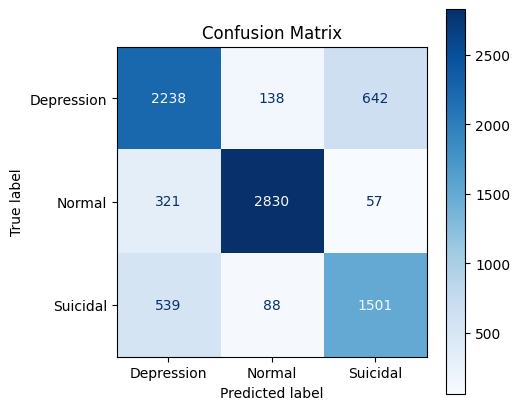

In [39]:
y_pred_nb = nb_pipeline.predict(X_test)

print(classification_report(y_test, y_pred_nb))

fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb, cmap="Blues", ax=ax)

plt.title("Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

  Depression       0.82      0.71      0.76      3018
      Normal       0.93      0.95      0.94      3208
    Suicidal       0.67      0.77      0.71      2128

    accuracy                           0.82      8354
   macro avg       0.80      0.81      0.80      8354
weighted avg       0.82      0.82      0.82      8354



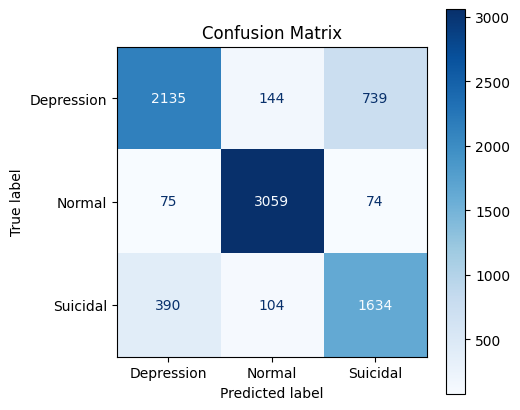

In [32]:
y_pred_lr = lr_pipeline.predict(X_test)

print(classification_report(y_test, y_pred_lr))

fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, cmap="Blues", ax=ax)

plt.title("Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

  Depression       0.82      0.73      0.77      3018
      Normal       0.90      0.97      0.94      3208
    Suicidal       0.70      0.72      0.71      2128

    accuracy                           0.82      8354
   macro avg       0.81      0.81      0.81      8354
weighted avg       0.82      0.82      0.82      8354



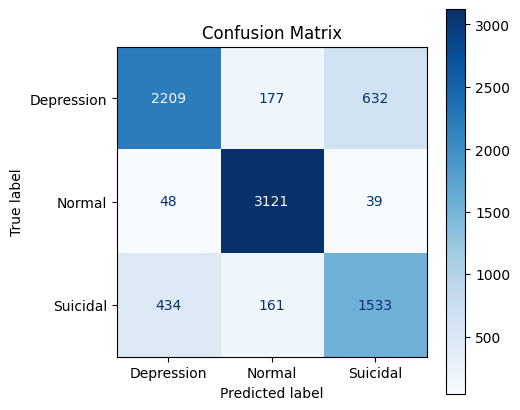

In [33]:
y_pred_svc = svc_pipeline.predict(X_test)

print(classification_report(y_test, y_pred_svc))

fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svc, cmap="Blues", ax=ax)

plt.title("Confusion Matrix")
plt.show()

## 6. Case Study



 CLASS: Depression

[CORRECT PREDICTION] Random Text snippet: i can go walking , not go last very long . i could read a book outside , i do not really read much . i could just get some food eat outside , i feel awkward about people judge me . when i do spend time outside , i do not have much do , i end up watch others , which not only make me feel like a bit a creep , also make me sad see everyone else enjoy themselves . i wish i could enjoy other thing outside since i know i feel well out there , not have anything do while outside sometimes feels bad . spending time outside tend make me feel well , i have nothing do outside ....


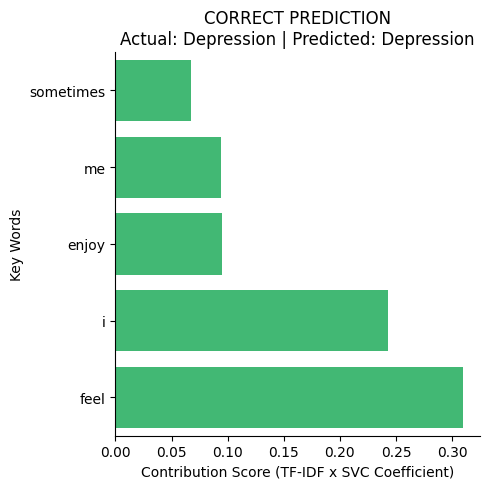


[WRONG PREDICTION] Random Text snippet: i 22 have no real hope future . i attempt college multiple time each time i end up have a total mental breakdown where i completely detach from reality end up hospitalize , cause me fall behind class . i have hospitalize many time i cannot even count ( more than 5 , less than 15 time ). now i work a fucking ice cream shop feel / look like shit everyday . all i do wake up , lay bed , go work , come home super late , lay bed , repeat . day off almost worst than work day since i have much time just mope do nothing . i have pretty much completely isolate myself from my friend family since i feel like such a loser . all i can think about how disappointed they me how much more functional successful they . socializing have also just become highly drain generali never know what say since i do not do shit have no real goal . only person i want see / communicate my ex he live three hr away from me leave me due my illness anyway . we still talk everyday kn

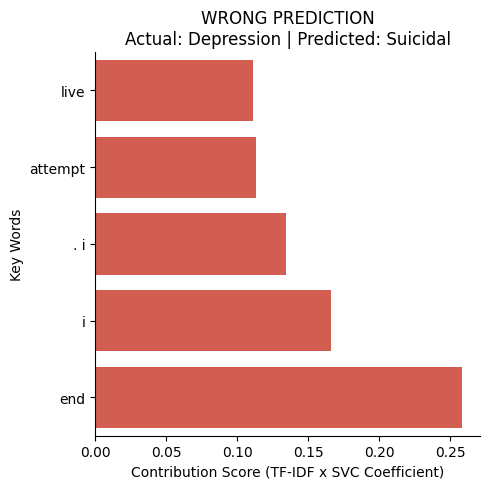


 CLASS: Normal

[CORRECT PREDICTION] Random Text snippet: ay depot lang...
No positive contributing features found for this CORRECT PREDICTION.

[WRONG PREDICTION] Random Text snippet: i make a decision i have enough fear i go die fight not afraid anymore . i reach point a few year ago . a wonderful thing sleep peacefully . i tire want sleep my trunk my car ( my garage ) because i afraid sleep alone house . i tire sleep sofa floor different room just avoid sleep bedroom because fear ....


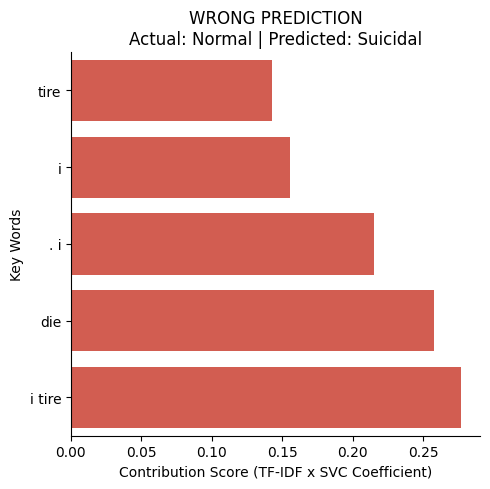


 CLASS: Suicidal

[CORRECT PREDICTION] Random Text snippet: not live exist i cannot stand , i cannot stand waking feel anxious try go back sleep very muddled confused just get more work up . i want my life back i want no life all . please please please make stop please i cannot do everyday , every single day , i just drag myself through them ....


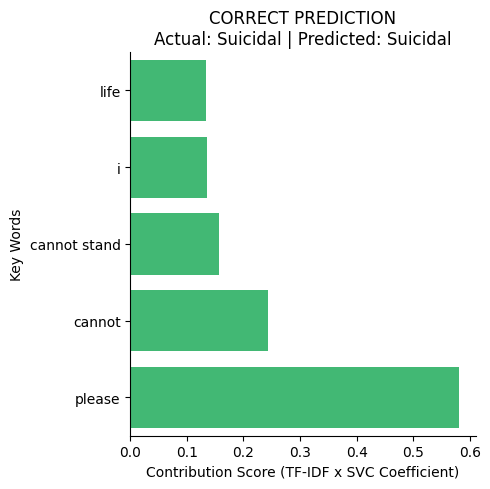


[WRONG PREDICTION] Random Text snippet: i feel like i definitely not allow cry show emotion , yesterday even i try write about my emotion me i felt like even write i feel sad a failure make me a weak person . i feel like if i cry mean i too sensitive i just need stop wet . weird when come joke stuff like take a lot offend me make me feel uncomfortable i have a very dark sense humour , aspect i would not say i very sensitive , however if i a bad mood someone could make a simple throw - away comment i would get offend . like i do not understand myself honest . i feel like eat my emotion feel like only way deal my emotion because i feel like most people cope their mental health constantly use humour do make people who cope their mental health cry , weird weak they just too sensitive i eat my emotion i do not know how get out...


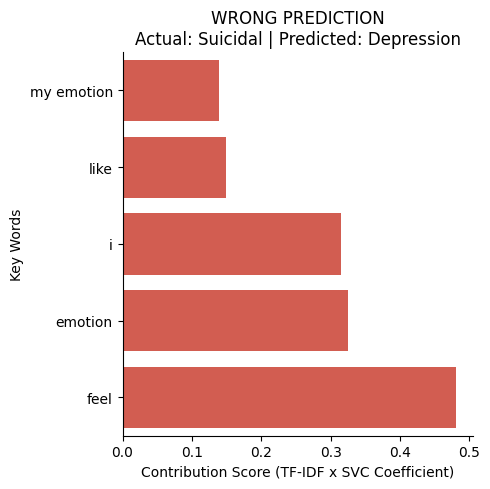

In [34]:
def plot_local_importance(pipeline, text, actual_label, pred_label, sample_type):
    tfidf = pipeline.named_steps["tfidf"]
    svc = pipeline.named_steps["svc"]

    x_vec = tfidf.transform([text])
    class_labels = list(svc.classes_)
    pred_idx = class_labels.index(pred_label)

    x_dense = x_vec.toarray()[0]
    weights = svc.coef_[pred_idx]
    if hasattr(weights, "toarray"):
        weights = weights.toarray()[0]
    else:
        weights = weights.flatten()

    # 3. Calculate importance
    importance = x_dense * weights
    feature_names = tfidf.get_feature_names_out()
    indices = np.argsort(importance)[-5:]
    plot_indices = [i for i in indices if importance[i] > 0]

    if not plot_indices:
        print(f"No positive contributing features found for this {sample_type}.")
        return

    values = importance[plot_indices]
    names = feature_names[plot_indices]

    plt.figure(figsize=(5, 5))
    color = "#2ecc71" if "CORRECT" in sample_type else "#e74c3c"

    sns.barplot(x=values, y=names, color=color)
    plt.title(
        f"{sample_type}\nActual: {actual_label} | Predicted: {pred_label}", fontsize=12
    )
    plt.xlabel("Contribution Score (TF-IDF x SVC Coefficient)", fontsize=10)
    plt.ylabel("Key Words", fontsize=10)
    sns.despine()
    plt.tight_layout()
    plt.show()


def analyze_visual_random(pipeline, X_val, y_val):
    y_pred = pipeline.predict(X_val)
    results = pd.DataFrame({"text": X_val, "actual": y_val, "pred": y_pred})
    classes = sorted(results["actual"].unique())

    for cls in classes:
        print("\n" + "=" * 60)
        print(f" CLASS: {cls}")
        print("=" * 60)

        correct_pool = results[(results["actual"] == cls) & (results["pred"] == cls)]
        wrong_pool = results[(results["actual"] == cls) & (results["pred"] != cls)]

        samples = [
            ("CORRECT PREDICTION", correct_pool),
            ("WRONG PREDICTION", wrong_pool),
        ]

        for label, pool in samples:
            if pool.empty:
                continue

            # Select a random sample from the pool
            data = pool.sample(n=1).iloc[0]

            text_val = data["text"]
            actual_val = data["actual"]
            pred_val = data["pred"]

            print(f"\n[{label}] Random Text snippet: {text_val}...")
            plot_local_importance(pipeline, text_val, actual_val, pred_val, label)


analyze_visual_random(svc_pipeline, X_test, y_test)

In [35]:
svc_pipeline = joblib.load(os.path.join(MODEL_DIR, "svc_pipeline.pkl"))

Analyzing Importance for: Depression


/tmp/ipykernel_4284/2042716142.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights[plot_indices], y=feature_names[plot_indices], palette="magma")


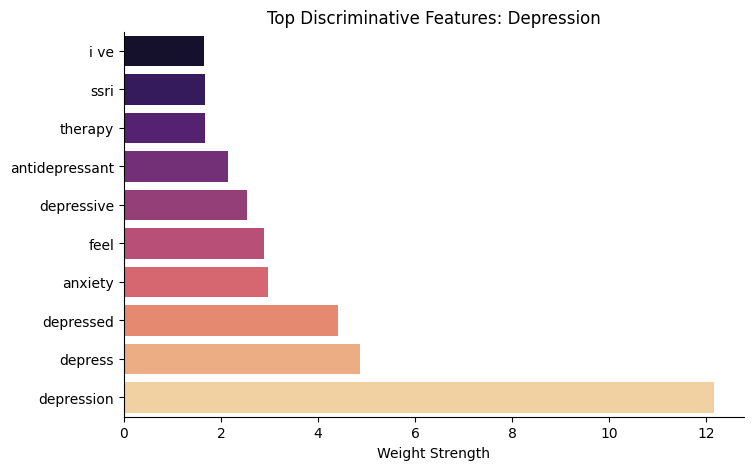

Analyzing Importance for: Normal


/tmp/ipykernel_4284/2042716142.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights[plot_indices], y=feature_names[plot_indices], palette="magma")


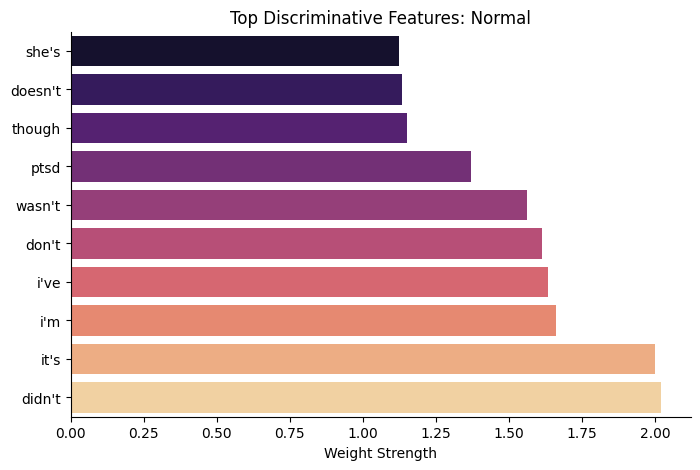

/tmp/ipykernel_4284/2042716142.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights[plot_indices], y=feature_names[plot_indices], palette="magma")


Analyzing Importance for: Suicidal


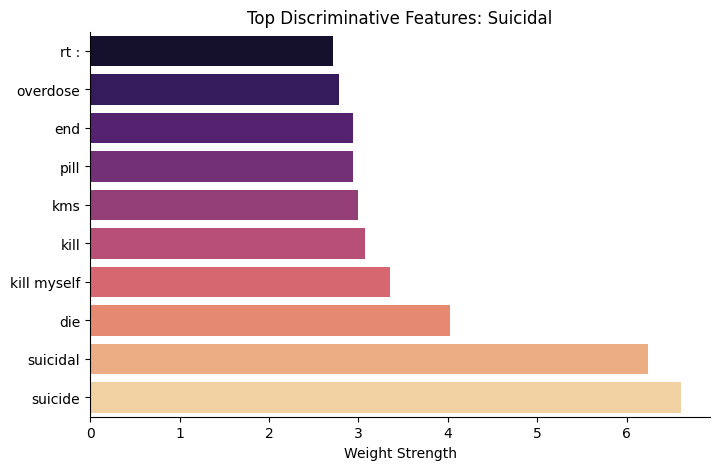

In [36]:
def plot_linear_svc_importance(pipeline, target_class, top_n=10):
    tfidf = pipeline.named_steps["tfidf"]
    svc = pipeline.named_steps["svc"]

    feature_names = tfidf.get_feature_names_out()
    classes = list(svc.classes_)
    target_idx = classes.index(target_class)

    # LinearSVC coef_ is (n_classes, n_features) for multi-class
    # For binary, it's (1, n_features)
    if svc.coef_.shape[0] == 1:
        weights = svc.coef_[0] if target_idx == 1 else -svc.coef_[0]
    else:
        weights = svc.coef_[target_idx]

    # Get indices of the top N weights
    indices = np.argsort(weights)[-top_n:]

    # Validation: Filter out weights that are effectively zero or negative
    # This prevents 'leaked' features from other classes showing up
    plot_indices = [i for i in indices if weights[i] > 0]

    if not plot_indices:
        print(f"No positive features found for {target_class}")
        return

    plt.figure(figsize=(8, 5))
    sns.barplot(x=weights[plot_indices], y=feature_names[plot_indices], palette="magma")
    plt.title(f"Top Discriminative Features: {target_class}", fontsize=12)
    plt.xlabel("Weight Strength")
    sns.despine()
    plt.show()


# Loop through all available classes (Normal, Depression, Suicidal, etc.)
for cls in svc_pipeline.named_steps["svc"].classes_:
    print(f"Analyzing Importance for: {cls}")
    plot_linear_svc_importance(svc_pipeline, cls)